In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fco2dataset.ucruise import divide_cruise

NUM_BINS = 64
WINDOW_LEN = 5

dss = []
total_cruises = 0
total_segments = 0
expcode_offset = 0
dfs = []
for year in range(1982, 2022):
    # Load interpolated data
    fname_interp_socat = f'../data/SOCATv2024_interpolated2/.gridded_2d_ocean_data_for_ML/SOCATv2024-cruise_tracks_interp-collocated/socat2024-interp_tracks-collocated-{year}.pq'
    df_interp_socat = pd.read_parquet(fname_interp_socat)
    df_interp_socat.set_index(['expocode', 'time_1d', 'lat', 'lon'], inplace=True)
    df_interp_socat = df_interp_socat.astype(np.float32, errors='ignore')
    #df_interp_socat = df_interp_socat.groupby(level=[0,1,2,3]).mean()

    cruises = len(df_interp_socat.index.unique(level=0))
    total_cruises += cruises
    print(f"number of cruises in {year}: {cruises}")

    # read raw socat data
    fname_socat = f'../data/SOCATv2024_raw-collocated-1982_2021/SOCATv2024_raw_r20250307-1982_2021/SOCATv2024v_collocated-{year}.pq'
    df_socat = pd.read_parquet(fname_socat)
    df_socat['time_1d'] = df_socat['time'].dt.round('D')
    df_socat.set_index(['expocode', 'time_1d','lat', 'lon'], inplace=True)
    df_socat = df_socat.astype(np.float32, errors='ignore')
    df_socat['interpolated'] = False

    df = pd.concat([df_socat, df_interp_socat], axis=0)
    print(df.shape)
    df2 = df.groupby(level='expocode', group_keys=False).apply(
        lambda cruise: divide_cruise(
            cruise,
            num_windows=NUM_BINS,
            len_window=WINDOW_LEN,
            max_time_delta=pd.Timedelta(days=2),
        )
    )

    dfs.append(df2)

df = pd.concat(dfs, axis=0)


number of cruises in 1982: 8
(11391, 24)
number of cruises in 1983: 7
(15142, 24)
number of cruises in 1984: 5
(13119, 24)
number of cruises in 1985: 9
(21579, 24)
number of cruises in 1986: 11
(28840, 24)
number of cruises in 1987: 19
(45267, 24)
number of cruises in 1988: 13
(30376, 24)
number of cruises in 1989: 15
(27991, 24)
number of cruises in 1990: 15
(25717, 24)
number of cruises in 1991: 28
(83366, 24)
number of cruises in 1992: 35
(103641, 24)
number of cruises in 1993: 33
(155067, 29)
number of cruises in 1994: 43
(207006, 29)
number of cruises in 1995: 82
(498637, 29)
number of cruises in 1996: 73
(361000, 29)
number of cruises in 1997: 68
(413646, 35)
number of cruises in 1998: 83
(414136, 35)
number of cruises in 1999: 63
(352679, 35)
number of cruises in 2000: 69
(389405, 35)
number of cruises in 2001: 76
(500724, 35)
number of cruises in 2002: 135
(640902, 35)
number of cruises in 2003: 140
(614843, 35)
number of cruises in 2004: 190
(912734, 35)
number of cruises in 2

In [7]:
df.interpolated = df.interpolated.astype(bool)

In [8]:
df.dtypes

sal                             float32
sst_deg_c                       float32
pppp_hpa                        float32
woa_sss                         float32
ncep_slp_hpa                    float32
dist_to_land_km                 float32
fco2rec_uatm                    float32
fco2rec_flag                    float32
time                     datetime64[ns]
year                            float32
temp_soda                       float32
salt_soda                       float32
mld_dens_soda                   float32
lon_soda                        float32
lat_soda                        float32
depth_soda                      float32
time_soda                datetime64[ns]
sst_cci                         float32
sst_cci_uncertainty             float32
ice_cci                         float32
time_sstcci              datetime64[ns]
lat_sstcci                      float32
lon_sstcci                      float32
interpolated                       bool
bin_id                            int32


In [10]:
# # save df to parquet
df.to_parquet(
    '../data/training_data/SOCAT_1982_2021_collocated_augm_binned.pq',
    index=True,
)

In [ ]:
df.reset_index(inplace=True)
df_grouped = df.groupby(['expocode', 'window_id']).mean()
df_grouped.reset_index(inplace=True)

df_grouped.to_parquet(
    '../data/training_data/SOCAT_1982_2021_grouped_colloc_augm_bin.pq',
    index=False,
)

read the binned dataset

In [4]:
import pandas as pd
df = pd.read_parquet(
    '../data/training_data/SOCAT_1982_2021_grouped_colloc_augm_bin.pq',  
)
df.set_index(['expocode', 'lat', 'lon'], inplace=True)

In [5]:
from sklearn import metrics
def plot_line_comparison(ax, y, yhat, **kwargs):
    from scipy.stats import pearsonr

    y.plot(ax=ax, **(kwargs | dict(label='SOCAT')))
    yhat.plot(ax=ax, **kwargs)
    
    m = y.notnull() & yhat.notnull()
    y = y[m]
    yhat = yhat[m]
    
    metric_txt = (
        f"r2 = {metrics.r2_score(y, yhat):.2f}"
        f"\nRMSE = {metrics.root_mean_squared_error(y, yhat):.1f}"
        f"\nBias = {(yhat - y).mean():.1f}"
        f"\nPearson R = {pearsonr(y, yhat)[0]:.2f}")
    
    ax.text(0.01, 0.04, metric_txt, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom')
    
    ax.legend()

In [6]:
expocodes = df.index.unique(level='expocode').values
#expocode = expocodes[6134]
expocode = "33GG20170721"
expocode

'33GG20170721'

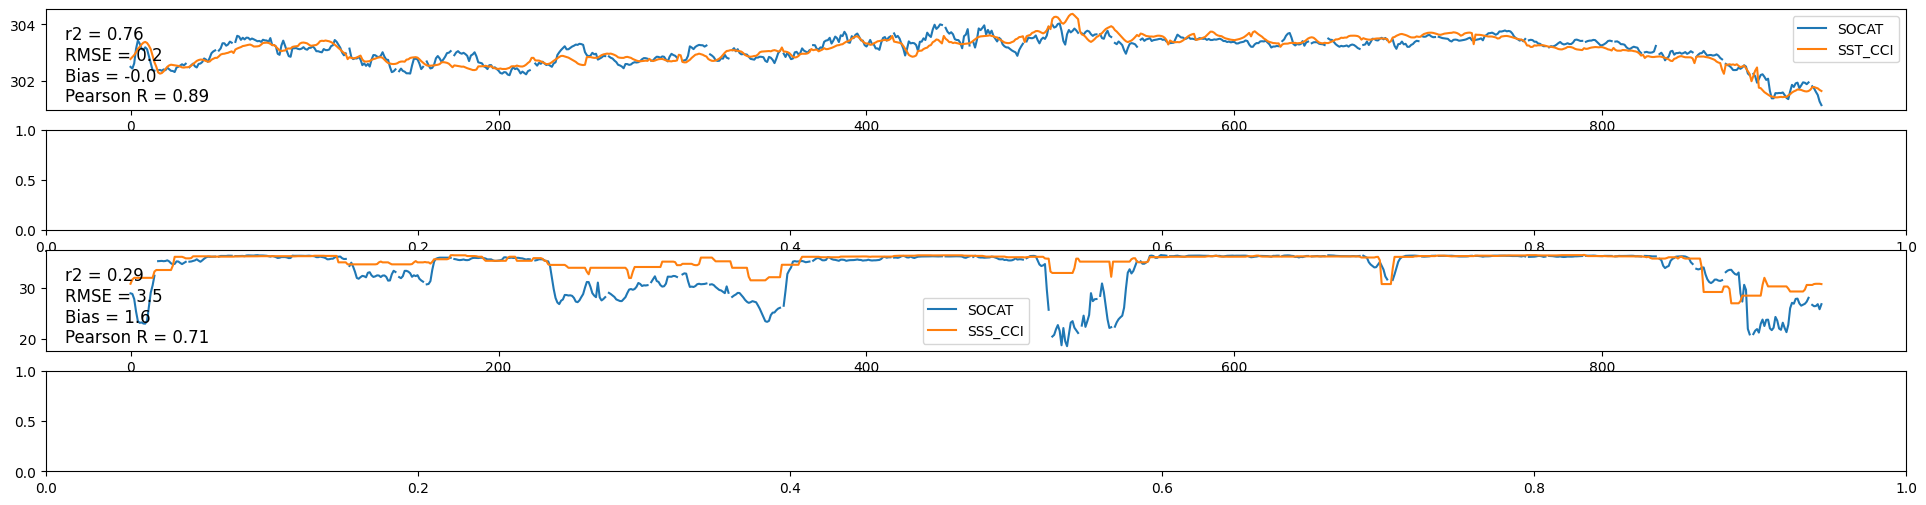

In [8]:
import matplotlib.pyplot as plt
cruise = df.loc[expocode].reset_index()
#cruise_binned = df.loc[expocode].groupby('window_id').mean().reset_index()

fig, axs = plt.subplots(4, 1, figsize=(2*12, 6))
plot_line_comparison(axs[0], cruise.sst_deg_c+273.15, cruise.sst_cci, label='SST_CCI')
#plot_line_comparison(axs[1], cruise_binned.sst_deg_c+273.15, cruise_binned.sst_cci, label='SST_CCI binned')
plot_line_comparison(axs[2], cruise.sal, cruise.salt_soda, label='SSS_CCI')
#plot_line_comparison(axs[3], cruise_binned.sal, cruise_binned.salt_soda, label='SSS_CCI binned')
